<a href="https://colab.research.google.com/github/efraimry/LSTM-Multi-Stock-BBRI-BMRI/blob/main/LSTM_Multi_Stock_7day_BBRI_BMRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**FINETUNING**


In [ ]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.5 MB/s eta 0:00:00


Trial 12 Complete [00h 00m 44s]
val_loss: 0.017359672114253044

Best val_loss So Far: 0.008090122602880001
Total elapsed time: 00h 08m 14s

✅ Best hyperparameters found:
  lstm_layers: 3
  units: 128
  dropout: 0.1
  lr: 0.001

🔁 Retraining best model on train+val (with early stopping)...
Epoch 1/60


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 36 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0130 - mae: 0.0864 - val_loss: 0.0256 - val_mae: 0.1324
Epoch 2/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0099 - mae: 0.0751 - val_loss: 0.0120 - val_mae: 0.0974
Epoch 3/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0092 - mae: 0.0740 - val_loss: 0.0132 - val_mae: 0.0975
Epoch 4/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0080 - mae: 0.0695 - val_loss: 0.0155 - val_mae: 0.1009
Epoch 5/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0099 - mae: 0.0775 - val_loss: 0.0078 - val_mae: 0.0751
Epoch 6/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0069 - mae: 0.0647 - val_loss: 0.0131 - val_mae: 0.0923
Epoch 7/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0068 - mae: 0.0635 - val_loss: 0.0344 - val_mae: 0.1623
Epoch 8/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0062 - mae: 0.0602 - val_loss: 0.0172 - val_mae: 0.1067
Epoch 9/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0062 - mae: 0.


📊 BBRI.JK Metrics:
RMSE: 271.24
MAE:  219.32
MAPE: 5.71%

📊 BMRI.JK Metrics:
RMSE: 385.61
MAE:  307.32
MAPE: 6.31%

✅ Best model saved to: models/best_lstm_multi_stock_7d.h5
✅ Scalers + metadata saved to: pipeline/scalers_and_meta.pkl and meta.json


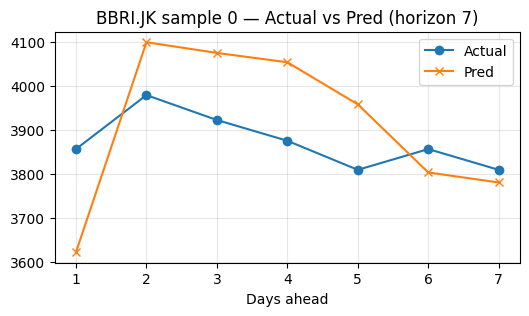

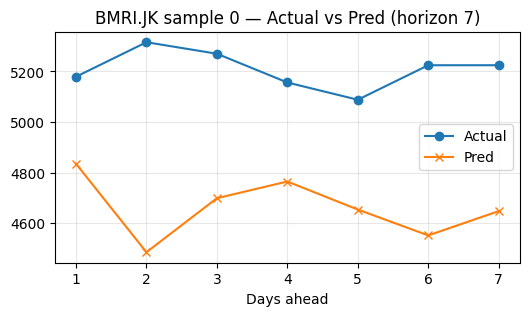


🎉 Tuning complete — periksa folder tuner_runs untuk logs.


In [ ]:
# hyper_tune_multi_stock.py
import os
import json
import joblib
import numpy as np
import pandas as pd
import yfinance as yf
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ----------------------------- Config -------------------------------------
DEFAULT_TICKERS = ["BBRI.JK", "BMRI.JK"]
SEQ_LEN = 60
# Note: HORIZON will remain fixed here (7). If you want tuner to try horizons, we can extend.
HORIZON = 7
TEST_SIZE = 0.12
VAL_SIZE = 0.12
EPOCHS = 60            # max epochs per trial (EarlyStopping will usually stop earlier)
MAX_TRIALS = 12        # number of hyperparameter trials for Bayesian tuner
EXECUTIONS_PER_TRIAL = 1
PROJECT_DIR = "tuner_runs"
MODEL_DIR = "models"
PIPELINE_DIR = "pipeline"
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(PIPELINE_DIR, exist_ok=True)
os.makedirs(PROJECT_DIR, exist_ok=True)

# ------------------------- Data utilities --------------------------------
def fetch_data(tickers, start=None, end=None, interval="1d"):
    raw = {}
    for t in tickers:
        print(f"Fetching {t}...")
        df = yf.download(t, start=start, end=end, interval=interval, progress=False)
        if df.empty:
            raise ValueError(f"No data fetched for {t}.")
        df.dropna(inplace=True)
        raw[t] = df
    return raw

def add_technical_indicators(df):
    df = df.copy()
    df['MA7'] = df['Close'].rolling(window=7, min_periods=1).mean()
    df['MA21'] = df['Close'].rolling(window=21, min_periods=1).mean()
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    ma_up = up.rolling(window=14, min_periods=1).mean()
    ma_down = down.rolling(window=14, min_periods=1).mean()
    rs = ma_up / (ma_down + 1e-8)
    df['RSI14'] = 100 - (100 / (1 + rs))
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    df['ATR14'] = tr.rolling(window=14, min_periods=1).mean()
    df.fillna(method='bfill', inplace=True)
    df.fillna(method='ffill', inplace=True)
    return df

def prepare_multi_stock_dataset(dict_dfs, seq_len=SEQ_LEN, horizon=HORIZON):
    tickers = list(dict_dfs.keys())
    n_stocks = len(tickers)
    feature_cols = ['Close', 'MA7', 'MA21', 'EMA12', 'EMA26', 'MACD', 'RSI14', 'ATR14']

    # align dates
    common_idx = None
    for df in dict_dfs.values():
        common_idx = df.index if common_idx is None else common_idx.intersection(df.index)
    for t in tickers:
        dict_dfs[t] = dict_dfs[t].loc[common_idx].copy()

    scalers = {}
    scaled_arrays = []
    for t in tickers:
        scaler = MinMaxScaler()
        arr = dict_dfs[t][feature_cols].values
        scaled = scaler.fit_transform(arr)
        scalers[t] = scaler
        scaled_arrays.append(scaled)

    stacked = np.concatenate(scaled_arrays, axis=1)  # shape (N, n_features_total)
    X, Y = [], []
    for i in range(seq_len, len(stacked) - horizon + 1):
        X.append(stacked[i - seq_len:i, :])
        y_seq = []
        for j in range(horizon):
            day_vals = [stacked[i + j, si * len(feature_cols)] for si in range(n_stocks)]
            y_seq.append(day_vals)
        Y.append(np.array(y_seq))
    X = np.array(X)
    Y = np.array(Y).reshape(len(X), horizon * n_stocks)
    return X, Y, scalers, feature_cols, tickers

# ------------------------- Metrics / Utils -------------------------------
def unscale_predictions(y_flat, scalers, tickers, feature_cols):
    samples = y_flat.shape[0]
    n_stocks = len(tickers)
    horizon = y_flat.shape[1] // n_stocks
    y = y_flat.reshape(samples, horizon, n_stocks)
    y_unscaled = np.zeros_like(y)
    for si, t in enumerate(tickers):
        scaler = scalers[t]
        for samp in range(samples):
            for h in range(horizon):
                scaled_close = y[samp, h, si]
                n_features = len(feature_cols)
                arr_scaled = np.zeros((1, n_features)) + scaled_close
                inv = scaler.inverse_transform(arr_scaled)
                y_unscaled[samp, h, si] = inv[0, 0]
    return y_unscaled

def evaluate_predictions(y_true, y_pred, tickers):
    from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
    n_stocks = y_true.shape[2]
    metrics = {}
    for si, t in enumerate(tickers):
        true_vals = y_true[:, :, si].flatten()
        pred_vals = y_pred[:, :, si].flatten()
        rmse = np.sqrt(mean_squared_error(true_vals, pred_vals))
        mae = mean_absolute_error(true_vals, pred_vals)
        mape = mean_absolute_percentage_error(true_vals, pred_vals) * 100
        metrics[t] = {"rmse": float(rmse), "mae": float(mae), "mape": float(mape)}
        print(f"\n📊 {t} Metrics:")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAE:  {mae:.2f}")
        print(f"MAPE: {mape:.2f}%")
    return metrics

# ------------------------- Keras-Tuner model builder ----------------------
def make_builder(seq_len, n_features, n_stocks, horizon):
    def build_model(hp):
        lstm_layers = hp.Int("lstm_layers", 2, 4, step=1)
        units = hp.Int("units", 64, 256, step=64)
        dropout = hp.Float("dropout", 0.1, 0.4, step=0.1)
        lr = hp.Choice("lr", [1e-4, 5e-4, 1e-3])
        # build model using same architecture style as yours
        inp = Input(shape=(seq_len, n_features))
        x = inp
        for i in range(lstm_layers):
            return_seq = (i < lstm_layers - 1)
            x = LSTM(units, return_sequences=return_seq)(x)
            x = BatchNormalization()(x)
            x = Dropout(dropout)(x)
        out = Dense(horizon * n_stocks, activation='linear')(x)
        model = Model(inp, out)
        model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['mae'])
        return model
    return build_model

# ------------------------- Main Tuning Workflow ---------------------------
if __name__ == "__main__":
    # 1) Load & prepare data (use same timeframe as before)
    start = '2019-01-01'
    raw = fetch_data(DEFAULT_TICKERS, start=start)
    for t in DEFAULT_TICKERS:
        raw[t] = add_technical_indicators(raw[t])

    # 2) Build dataset
    X, Y, scalers, feature_cols, tickers = prepare_multi_stock_dataset(raw, seq_len=SEQ_LEN, horizon=HORIZON)
    n_features = X.shape[2]
    n_stocks = len(tickers)
    print(f"Dataset shapes -> X: {X.shape}, Y: {Y.shape}, n_features: {n_features}, n_stocks: {n_stocks}")

    # 3) Train/val/test split (time-series style, no shuffle)
    X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, shuffle=False)
    val_relative = VAL_SIZE / (1 - TEST_SIZE)
    X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=val_relative, shuffle=False)
    print(f"Split -> train: {X_train.shape}, val: {X_val.shape}, test: {X_test.shape}")

    # 4) Create tuner
    builder = make_builder(SEQ_LEN, n_features, n_stocks, HORIZON)
    tuner = kt.BayesianOptimization(
        builder,
        objective="val_loss",
        max_trials=MAX_TRIALS,
        executions_per_trial=EXECUTIONS_PER_TRIAL,
        directory=PROJECT_DIR,
        project_name="lstm_multi_stock_bayes"
    )

    # 5) Early stopping for each trial
    stop_early = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)

    # 6) Run search
    print("\n🔎 Starting tuner search (this may take a while)...")
    tuner.search(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=EPOCHS,
        batch_size=32,                 # fixed batch size for tuner search; we can also tune batch size if desired
        callbacks=[stop_early],
        verbose=1
    )

    # 7) Get best hyperparameters + model
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print("\n✅ Best hyperparameters found:")
    for k, v in best_hps.values.items():
        print(f"  {k}: {v}")

    best_model = tuner.get_best_models(num_models=1)[0]

    # 8) Optional: retrain best model on (train + val) for robustness
    print("\n🔁 Retraining best model on train+val (with early stopping)...")
    X_combined = np.concatenate([X_train, X_val], axis=0)
    Y_combined = np.concatenate([Y_train, Y_val], axis=0)
    stop_final = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
    history = best_model.fit(
        X_combined, Y_combined,
        validation_split=0.12,  # small val-split to monitor during retrain
        epochs=EPOCHS,
        batch_size=32,
        callbacks=[stop_final],
        verbose=1
    )

    # 9) Evaluate on test set
    print("\n📐 Evaluating best model on TEST set...")
    y_pred_flat = best_model.predict(X_test)
    y_pred_unscaled = unscale_predictions(y_pred_flat, scalers, tickers, feature_cols)
    y_true_unscaled = unscale_predictions(Y_test, scalers, tickers, feature_cols)
    metrics = evaluate_predictions(y_true_unscaled, y_pred_unscaled, tickers)

    # 10) Save best model + scalers + metadata
    best_path = os.path.join(MODEL_DIR, 'best_lstm_multi_stock_7d.h5')
    best_model.save(best_path)
    meta = {
        "feature_cols": feature_cols,
        "seq_len": SEQ_LEN,
        "horizon": HORIZON,
        "tickers": tickers,
        "best_hyperparameters": best_hps.values
    }
    joblib.dump({"scalers": scalers, "meta": meta}, os.path.join(PIPELINE_DIR, 'scalers_and_meta.pkl'))
    with open(os.path.join(PIPELINE_DIR, 'meta.json'), 'w') as f:
        json.dump(meta, f, indent=2)
    print(f"\n✅ Best model saved to: {best_path}")
    print(f"✅ Scalers + metadata saved to: {PIPELINE_DIR}/scalers_and_meta.pkl and meta.json")

    # 11) (Optional) quick plots for the first sample in test
    try:
        import matplotlib.pyplot as plt
        sample_idx = 0
        horizon = y_true_unscaled.shape[1]
        for si, t in enumerate(tickers):
            plt.figure(figsize=(6,3))
            plt.plot(np.arange(1, horizon+1), y_true_unscaled[sample_idx,:,si], marker='o', label='Actual')
            plt.plot(np.arange(1, horizon+1), y_pred_unscaled[sample_idx,:,si], marker='x', label='Pred')
            plt.title(f"{t} sample {sample_idx} — Actual vs Pred (horizon {horizon})")
            plt.xlabel("Days ahead")
            plt.legend()
            plt.grid(alpha=0.3)
            plt.show()
    except Exception:
        pass

    print("\n🎉 Tuning complete — periksa folder tuner_runs untuk logs.")


#**LOAD MODEL**

In [4]:
import joblib
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
# === Load model dan scaler ===
model = load_model("models/best_lstm_multi_stock_7d.h5", custom_objects={"mse": tf.keras.losses.MeanSquaredError()})

pipeline = joblib.load("pipeline/scalers_and_meta.pkl")

scalers = pipeline["scalers"]
meta = pipeline["meta"]

feature_cols = meta["feature_cols"]
seq_len = meta["seq_len"]
horizon = meta["horizon"]
tickers = meta["tickers"]

print("✅ Model & scaler loaded.")
print("Tickers:", tickers)


✅ Model & scaler loaded.
Tickers: ['BBRI.JK', 'BMRI.JK']


In [19]:
import yfinance as yf
import pandas as pd
import numpy as np

tickers = ["BBRI.JK", "BMRI.JK"]

# === Ambil data terbaru dari Yahoo Finance ===
latest_raw = {}
for t in tickers:
    print(f"Fetching {t}...")
    df = yf.download(t, start="2019-01-01", interval="1d", progress=False)
    df.dropna(inplace=True)
    latest_raw[t] = df

# === Fungsi untuk menambah indikator teknikal ===
def add_technical_indicators(df):
    df = df.copy()
    df['MA7'] = df['Close'].rolling(window=7, min_periods=1).mean()
    df['MA21'] = df['Close'].rolling(window=21, min_periods=1).mean()
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']

    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    ma_up = up.rolling(window=14, min_periods=1).mean()
    ma_down = down.rolling(window=14, min_periods=1).mean()
    rs = ma_up / (ma_down + 1e-8)
    df['RSI14'] = 100 - (100 / (1 + rs))

    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    df['ATR14'] = tr.rolling(window=14, min_periods=1).mean()

    df.fillna(method='bfill', inplace=True)
    df.fillna(method='ffill', inplace=True)
    return df

# === Tambahkan indikator untuk semua ticker ===
for t in tickers:
    latest_raw[t] = add_technical_indicators(latest_raw[t])

# === Tampilkan data terbaru yang sudah diproses ===
for t in tickers:
    print(f"\n===== DATA MENTAH + INDIKATOR: {t} =====")
    print(latest_raw[t].tail(10))
    print(f"Kolom: {list(latest_raw[t].columns)}")
    print(f"Total baris: {len(latest_raw[t])}")
    print("-" * 60)


Fetching BBRI.JK...
Fetching BMRI.JK...


/tmp/ipython-input-3719049241.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start="2019-01-01", interval="1d", progress=False)
/tmp/ipython-input-3719049241.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start="2019-01-01", interval="1d", progress=False)
/tmp/ipython-input-3719049241.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipython-input-3719049241.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/tmp/ipython-input-3719049241.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='b


===== DATA MENTAH + INDIKATOR: BBRI.JK =====
Price        Close    High     Low    Open     Volume          MA7  \
Ticker     BBRI.JK BBRI.JK BBRI.JK BBRI.JK    BBRI.JK                
Date                                                                 
2025-10-27  3860.0  3930.0  3750.0  3880.0  332539600  3738.571429   
2025-10-28  3850.0  3860.0  3780.0  3850.0  239026800  3788.571429   
2025-10-29  3890.0  3890.0  3790.0  3830.0  215008600  3818.571429   
2025-10-30  3910.0  3990.0  3870.0  3900.0  287905300  3840.000000   
2025-10-31  3980.0  4020.0  3920.0  3930.0  348755700  3880.000000   
2025-11-03  4040.0  4050.0  4010.0  4050.0  163770500  3911.428571   
2025-11-04  3970.0  4050.0  3970.0  4030.0  241154700  3928.571429   
2025-11-05  3980.0  3990.0  3910.0  3940.0  139859100  3945.714286   
2025-11-06  4000.0  4010.0  3950.0  3980.0  130808100  3967.142857   
2025-11-07  3980.0  4010.0  3980.0  4000.0   87287600  3980.000000   

Price              MA21        EMA12       

In [8]:
# import yfinance as yf
# import pandas as pd

# # Ambil data terbaru (misalnya sampai hari ini)
# latest_raw = {}
# for t in tickers:
#     df = yf.download(t, start="2019-01-01", interval="1d", progress=False)
#     latest_raw[t] = df

# # --- ✅ Tampilkan dulu data mentah yang akan diolah ---
# for t in tickers:
#     print(f"\n===== DATA MENTAH: {t} =====")
#     print(raw[t].tail(10))  # tampilkan 10 baris terakhir (data terbaru)
#     print(f"Kolom: {list(raw[t].columns)}")
#     print(f"Total baris: {len(raw[t])}")
#     print("-" * 60)

# # Apply fungsi indikator seperti dulu
# def add_technical_indicators(df):
#     df = df.copy()
#     df['MA7'] = df['Close'].rolling(window=7, min_periods=1).mean()
#     df['MA21'] = df['Close'].rolling(window=21, min_periods=1).mean()
#     df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
#     df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
#     df['MACD'] = df['EMA12'] - df['EMA26']
#     delta = df['Close'].diff()
#     up = delta.clip(lower=0)
#     down = -delta.clip(upper=0)
#     ma_up = up.rolling(window=14, min_periods=1).mean()
#     ma_down = down.rolling(window=14, min_periods=1).mean()
#     rs = ma_up / (ma_down + 1e-8)
#     df['RSI14'] = 100 - (100 / (1 + rs))
#     high_low = df['High'] - df['Low']
#     high_close = np.abs(df['High'] - df['Close'].shift())
#     low_close = np.abs(df['Low'] - df['Close'].shift())
#     tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
#     df['ATR14'] = tr.rolling(window=14, min_periods=1).mean()
#     df.fillna(method='bfill', inplace=True)
#     df.fillna(method='ffill', inplace=True)
#     return df

# for t in tickers:
#     latest_raw[t] = add_technical_indicators(latest_raw[t])


Fetching BBRI.JK...
Fetching BMRI.JK...


/tmp/ipython-input-1364104021.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start="2019-01-01", interval="1d", progress=False)
/tmp/ipython-input-1364104021.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start="2019-01-01", interval="1d", progress=False)



===== DATA MENTAH: BBRI.JK =====


NameError: name 'raw' is not defined

In [20]:
X_input = []
for t in tickers:
    df = latest_raw[t].iloc[-seq_len:]
    arr = df[feature_cols].values
    scaler = scalers[t]
    arr_scaled = scaler.transform(arr)
    X_input.append(arr_scaled)

# Gabungkan antar saham (stacked horizontal)
X_input = np.concatenate(X_input, axis=1)
X_input = np.expand_dims(X_input, axis=0)  # shape (1, seq_len, n_features_total)


In [21]:
y_pred_scaled = model.predict(X_input)
print("y_pred_scaled shape:", y_pred_scaled.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
y_pred_scaled shape: (1, 14)


In [22]:
def unscale_predictions(y_flat, scalers, tickers, feature_cols):
    n_stocks = len(tickers)
    horizon = y_flat.shape[1] // n_stocks
    y = y_flat.reshape(1, horizon, n_stocks)
    y_unscaled = np.zeros_like(y)
    for si, t in enumerate(tickers):
        scaler = scalers[t]
        for h in range(horizon):
            scaled_close = y[0, h, si]
            arr_scaled = np.zeros((1, len(feature_cols))) + scaled_close
            inv = scaler.inverse_transform(arr_scaled)
            y_unscaled[0, h, si] = inv[0, 0]
    return y_unscaled

y_pred_unscaled = unscale_predictions(y_pred_scaled, scalers, tickers, feature_cols)


In [23]:
import pandas as pd

dates = pd.date_range(start=latest_raw[tickers[0]].index[-1] + pd.Timedelta(days=1), periods=horizon, freq='B' )
for si, t in enumerate(tickers):
    print(f"\n📈 Prediksi {t} (7 hari ke depan):")
    preds = y_pred_unscaled[0, :, si]
    for d, p in zip(dates, preds):
        print(f"{d.date()} : {p:.2f}")



📈 Prediksi BBRI.JK (7 hari ke depan):
2025-11-10 : 3593.25
2025-11-11 : 4125.68
2025-11-12 : 4075.56
2025-11-13 : 4099.13
2025-11-14 : 3962.74
2025-11-17 : 3809.26
2025-11-18 : 3844.80

📈 Prediksi BMRI.JK (7 hari ke depan):
2025-11-10 : 4843.98
2025-11-11 : 4475.59
2025-11-12 : 4660.91
2025-11-13 : 4726.06
2025-11-14 : 4623.38
2025-11-17 : 4585.44
2025-11-18 : 4560.65


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


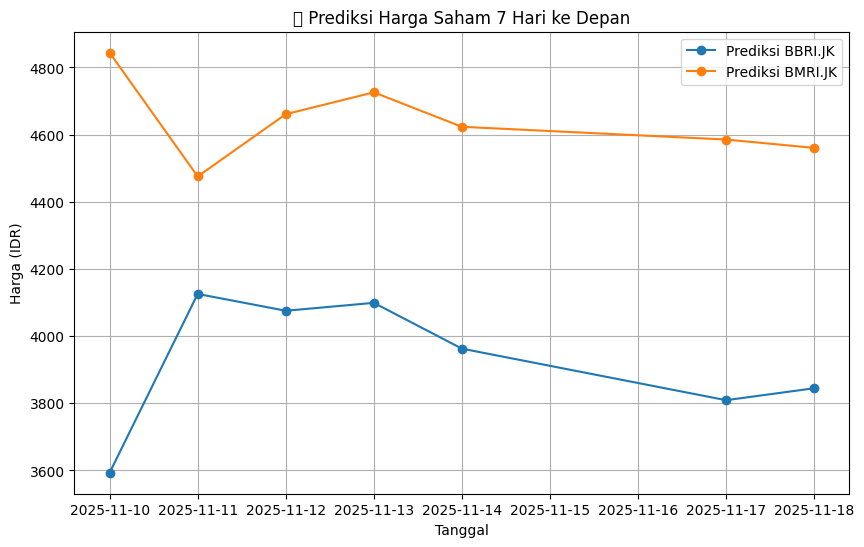

In [24]:
import matplotlib.pyplot as plt
import pandas as pd


dates = pd.date_range(
    start=latest_raw[tickers[0]].index[-1] + pd.Timedelta(days=1),
    periods=horizon,
    freq='B'
)

# === Visualisasi ===
plt.figure(figsize=(10, 6))

for si, t in enumerate(tickers):
    preds = y_pred_unscaled[0, :, si]
    plt.plot(dates, preds, marker='o', linestyle='-', label=f'Prediksi {t}')

plt.title('📈 Prediksi Harga Saham 7 Hari ke Depan')
plt.xlabel('Tanggal')
plt.ylabel('Harga (IDR)')
plt.legend()
plt.grid(True)
plt.show()



/tmp/ipython-input-3258621415.py:20: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y_vals = [float(last_price)] + preds.tolist()
/tmp/ipython-input-3258621415.py:29: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


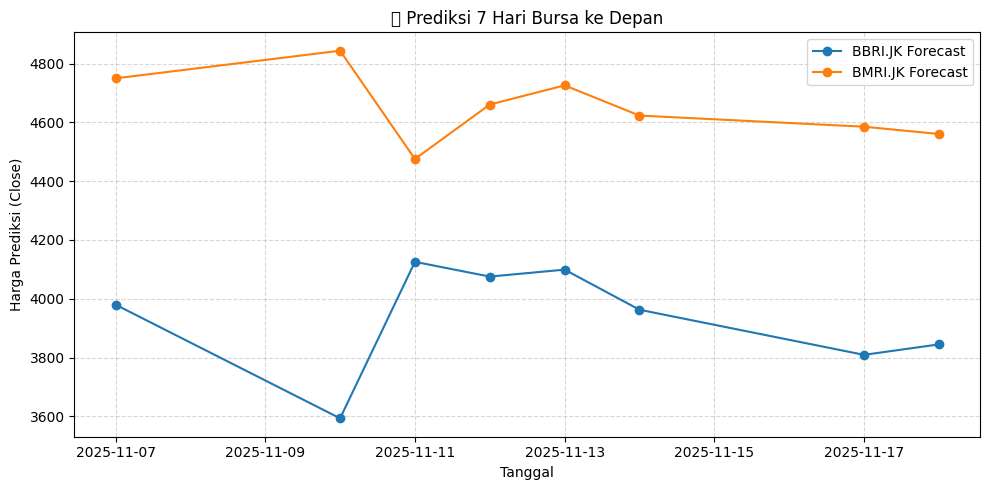

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

dates = pd.date_range(
    start=latest_raw[tickers[0]].index[-1] + pd.Timedelta(days=1),
    periods=horizon,
    freq='B'  # hanya hari kerja (Senin–Jumat)
)

plt.figure(figsize=(10, 5))

for si, t in enumerate(tickers):
    preds = np.array(y_pred_unscaled[0, :, si]).reshape(-1)
    last_date = latest_raw[t].index[-1]
    last_price = latest_raw[t]['Close'].iloc[-1]

    # ubah semua jadi datetime list
    x_vals = [last_date.to_pydatetime()] + [d.to_pydatetime() for d in dates]
    y_vals = [float(last_price)] + preds.tolist()

    plt.plot(x_vals, y_vals, marker='o', label=f'{t} Forecast')

plt.title("📈 Prediksi 7 Hari Bursa ke Depan")
plt.xlabel("Tanggal")
plt.ylabel("Harga Prediksi (Close)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
